In [1]:
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math

%matplotlib inline

In [2]:
# Reading the training set
Demographics_reduced = pd.read_csv('Demographics_reduced.csv')
Demographics_reduced.head(5)

print(Demographics_reduced.shape)

(16404, 9)


In [3]:
Demographics_reduced.describe()

,TotalChildren,YearlyIncome
count,16404.000000,16404.000000
mean,2.004511,78129.672397
std,1.682318,39728.383493
min,0.000000,9482.000000
25%,0.000000,47808.750000
50%,2.000000,76125.000000
75%,3.000000,105211.750000
max,5.000000,196511.000000


In [4]:
Demographics_reduced.head(10)

,Education,Occupation,Gender,MaritalStatus,TotalChildren,YearlyIncome,AgeGroup,CarGroup,Children
0,Bachelors,Professional,M,M,2,137947,Group_2,No_car,No_children
1,Bachelors,Professional,M,S,3,101141,Group_2,1-2,With_Children
2,Bachelors,Professional,M,M,3,91945,Group_2,1-2,With_Children
3,Bachelors,Professional,F,S,0,86688,Group_2,1-2,No_children
4,Bachelors,Professional,F,S,5,92771,Group_2,3 or more,With_Children
5,Bachelors,Professional,M,S,0,103199,Group_2,1-2,No_children
6,Bachelors,Professional,F,S,0,84756,Group_2,1-2,No_children
7,Bachelors,Professional,M,M,3,109759,Group_2,1-2,With_Children
8,Bachelors,Professional,F,S,4,88005,Group_2,3 or more,With_Children
9,Bachelors,Professional,M,S,0,106399,Group_2,1-2,No_children


In [5]:
# Reading the Test set
TestSet_reduced = pd.read_csv('TestSet_reduced.csv')
TestSet_reduced.head(5)
print(TestSet_reduced.shape)

(500, 9)


In [6]:
TestSet_reduced.head(10)

,Education,Occupation,Gender,MaritalStatus,TotalChildren,YearlyIncome,AgeGroup,CarGroup,Children
0,Bachelors,Management,F,S,5,86931,Group_3,1-2,No_children
1,Bachelors,Skilled Manual,M,M,4,100125,Group_2,1-2,With_Children
2,Graduate Degree,Management,F,M,4,103985,Group_4,1-2,No_children
3,Graduate Degree,Skilled Manual,M,M,4,127161,Group_2,No_car,No_children
4,High School,Manual,F,M,2,21876,Group_2,1-2,With_Children
5,Partial College,Clerical,F,M,1,44467,Group_2,1-2,No_children
6,Bachelors,Skilled Manual,M,S,4,77702,Group_2,1-2,With_Children
7,Bachelors,Professional,M,M,4,99418,Group_2,3 or more,With_Children
8,Partial High School,Manual,M,S,4,13522,Group_2,1-2,With_Children
9,Bachelors,Skilled Manual,F,M,1,46264,Group_1,1-2,With_Children


In [7]:
AveMonthSpend_reduced = pd.read_csv('AveMonthSpend_reduced.csv')
AveMonthSpend_reduced.head(10)

,AveMonthSpend
0,89
1,117
2,123
3,50
4,95
5,78
6,54
7,130
8,85
9,74


In [8]:
# Sanity check
AveMonthSpend_reduced.describe()
(AveMonthSpend_reduced.astype(np.object) == 'nan').any() # ?,NaN, etc
print(AveMonthSpend_reduced)

       AveMonthSpend
0                 89
1                117
2                123
3                 50
4                 95
...              ...
16399            101
16400             46
16401             79
16402             65
16403             68

[16404 rows x 1 columns]


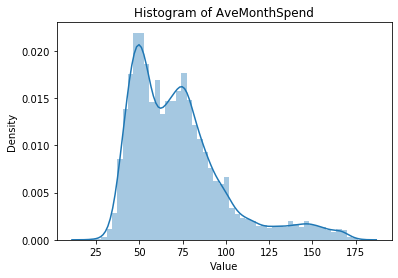

In [9]:
def hist_plot(vals, lab):
    ## Distribution plot of values
    sns.distplot(vals)
    plt.title('Histogram of ' + lab)
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    
hist_plot(AveMonthSpend_reduced['AveMonthSpend'],'AveMonthSpend')

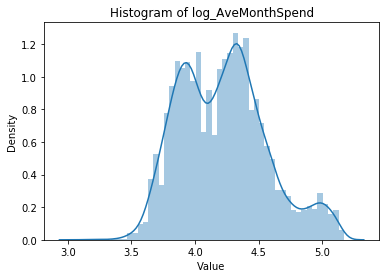

In [10]:
AveMonthSpend_reduced['log_AveMonthSpend'] = np.log(AveMonthSpend_reduced['AveMonthSpend'])
hist_plot(AveMonthSpend_reduced['log_AveMonthSpend'], 'log_AveMonthSpend')

## Prepare data for scikit-learn model

Creating the labels for scikitlear

In [11]:
labels = AveMonthSpend_reduced['log_AveMonthSpend'].values
np.where(np.isnan(labels) == True)

(array([], dtype=int64),)

In [12]:
# Define which are the categorical variables
cat_cols = [x  for x in Demographics_reduced.columns if pd.api.types.is_string_dtype(Demographics_reduced[x])]
print(cat_cols)

# Define which are the Numerical variables
numeric_cols = [x  for x in Demographics_reduced.columns if pd.api.types.is_numeric_dtype(Demographics_reduced[x])]
print(numeric_cols)

['Education', 'Occupation', 'Gender', 'MaritalStatus', 'AgeGroup', 'CarGroup', 'Children']
['TotalChildren', 'YearlyIncome']


create the numpy feature array or model matrix. As first step, the categorical variables need to be recoded as binary dummy variables. As discussed in another lesson this is a three step process:

Encode the categorical string variables as integers.
Transform the integer coded variables to dummy variables.
Append each dummy coded categorical variable to the model matrix.

In [13]:
def encode_string(cat_features):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

def categorical_features(df, cat_cols):
    """
    Returns a numpy array with the categorical variables encoded
    df data frame
    cat_cols categorical columns
    """
    # Creating the first Feature

    Features = encode_string(df[cat_cols[0]])

    for col in cat_cols[1::]:
        temp = encode_string((df[col]))
        print('***********************************\n')
        print("%s has %s dummy variables"%(col,len(df[col].unique())))
        print("These are the dummy variables %s"%(df[col].unique()))
        Features = np.concatenate([Features, temp], axis = 1)
    
    return Features


# For the training
Features = categorical_features(Demographics_reduced,cat_cols)

print(Features.shape)
print(Features[:2, :])   


# For the test

Features_test = categorical_features(TestSet_reduced,cat_cols)
print(Features_test.shape)
print(Features_test[:2, :])  


***********************************

Occupation has 5 dummy variables
These are the dummy variables ['Professional' 'Management' 'Skilled Manual' 'Clerical' 'Manual']
***********************************

Gender has 2 dummy variables
These are the dummy variables ['M' 'F']
***********************************

MaritalStatus has 2 dummy variables
These are the dummy variables ['M' 'S']
***********************************

AgeGroup has 4 dummy variables
These are the dummy variables ['Group_2' 'Group_1' 'Group_3' 'Group_4']
***********************************

CarGroup has 3 dummy variables
These are the dummy variables ['No_car' '1-2' '3 or more']
***********************************

Children has 2 dummy variables
These are the dummy variables ['No_children' 'With_Children']
(16404, 23)
[[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.]]
***********************************

Occupation has 5 dummy 

/Users/simon/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/simon/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories

Next the numeric features must be concatenated to the numpy array 

In [14]:
# For the Training 

Features = np.concatenate([Features, np.array(Demographics_reduced[numeric_cols])], axis = 1)
print(Features.shape)
print(Features[:2, :])  

# For the test 

Features_test = np.concatenate([Features_test, np.array(TestSet_reduced[numeric_cols])], axis = 1)
print(Features_test.shape)
print(Features_test[:2, :])  


(16404, 25)
[[1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 1.00000e+00 1.00000e+00 0.00000e+00 2.00000e+00
  1.37947e+05]
 [1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 1.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 3.00000e+00
  1.01141e+05]]
(500, 25)
[[1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
  0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 5.00000e+00
  8.69310e+04]
 [1.00000e+00 0.00000e+00 0.00000e+00 0.0000

### Create Test and Sample cases

In [15]:
## Randomly sample cases to create independent training and test data
nr.seed(9988)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 1500)
x_train = Features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(labels[indx[1]])

In [16]:
# Checking that the test has the same shape
print(np.shape(x_train))
print(np.shape(Features_test))

(14904, 25)
(500, 25)


### Scaling 

In [17]:
n_numerical = len(numeric_cols)
scaler = preprocessing.StandardScaler().fit(x_train[:,-n_numerical:])
x_train[:,-n_numerical:] = scaler.transform(x_train[:,-n_numerical:])
x_test[:,-n_numerical:] = scaler.transform(x_test[:,-n_numerical:])
x_train[:2,]

# Scaling the test

Features_test[:,-n_numerical:] = scaler.transform(Features_test[:,-n_numerical:])

## Construct the linear regression model

In [18]:
# Sanity check, here I made a mistake before
np.where(np.isnan(y_train)== True)

(array([], dtype=int64),)

Mean Square Error      = 0.007958605775187495
Root Mean Square Error = 0.08921101823871026
Mean Absolute Error    = 0.0691876760932261
Median Absolute Error  = 0.05778134785538569
R^2                    = 0.9318134100252877


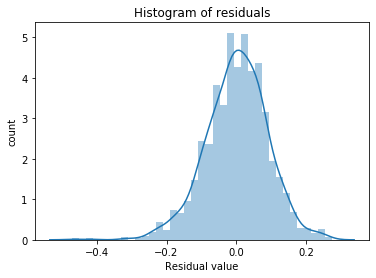

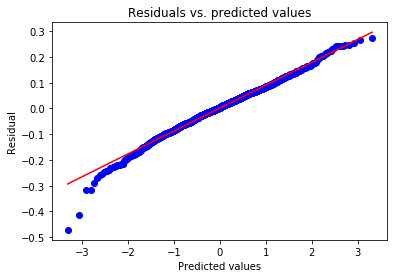

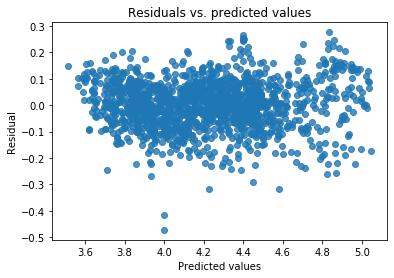

In [19]:
## define and fit the linear regression model
lin_mod = linear_model.LinearRegression(fit_intercept = False)
lin_mod.fit(x_train, y_train)

def print_metrics(y_true, y_predicted):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()

def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    plt.show()
    
def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()
  

y_score = lin_mod.predict(x_test) 
print_metrics(y_test, y_score) 
hist_resids(y_test, y_score)  
resid_qq(y_test, y_score) 
resid_plot(y_test, y_score) 

Any structure in this plot with change in predicted values indicates that the model fit changes with the predicted value. For example, if the residuals increase with predicted values the model can be said to predict only the smaller label values well. The opposite situation indicates that only large label values are well predicted. Changes in the mid-range indicate that there is some nonlinear change with predicted values. In other words, in any of these cases the model is not accurately computing the predicted values.

## Apply l2 regularization 

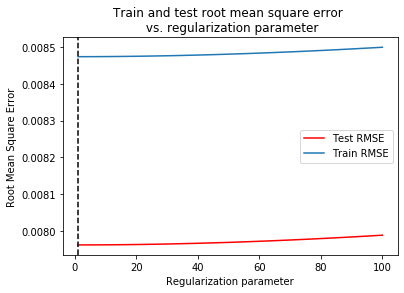

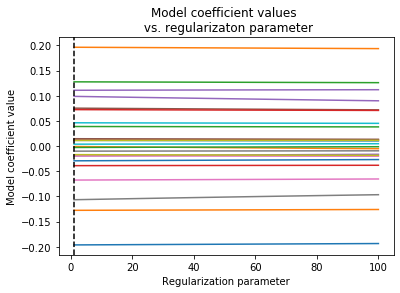

(1, 0.0079621649609028)


In [20]:
def plot_regularization(l, train_RMSE, test_RMSE, coefs, min_idx, title):   
    plt.plot(l, test_RMSE, color = 'red', label = 'Test RMSE')
    plt.plot(l, train_RMSE, label = 'Train RMSE')    
    plt.axvline(min_idx, color = 'black', linestyle = '--')
    plt.legend()
    plt.xlabel('Regularization parameter')
    plt.ylabel('Root Mean Square Error')
    plt.title(title)
    plt.show()
    
    plt.plot(l, coefs)
    plt.axvline(min_idx, color = 'black', linestyle = '--')
    plt.title('Model coefficient values \n vs. regularizaton parameter')
    plt.xlabel('Regularization parameter')
    plt.ylabel('Model coefficient value')
    plt.show()

def test_regularization_l2(x_train, y_train, x_test, y_test, l2):
    train_RMSE = []
    test_RMSE = []
    coefs = []
    for reg in l2:
        lin_mod = linear_model.Ridge(alpha = reg)
        lin_mod.fit(x_train, y_train)
        coefs.append(lin_mod.coef_)
        y_score_train = lin_mod.predict(x_train)
        train_RMSE.append(sklm.mean_squared_error(y_train, y_score_train))
        y_score = lin_mod.predict(x_test)
        test_RMSE.append(sklm.mean_squared_error(y_test, y_score))
    min_idx = np.argmin(test_RMSE)
    min_l2 = l2[min_idx]
    min_RMSE = test_RMSE[min_idx]
    
    title = 'Train and test root mean square error \n vs. regularization parameter'
    plot_regularization(l2, train_RMSE, test_RMSE, coefs, min_l2, title)
    return min_l2, min_RMSE
     
l2 = [x for x in range(1,101)]
out_l2 = test_regularization_l2(x_train, y_train, x_test, y_test, l2)
print(out_l2)

Recall that the logistic regression model outputs probabilities for each class. The class with the highest probability is taken as the score (prediction). 

Mean Square Error      = 0.0079621649609028
Root Mean Square Error = 0.08923096413747192
Mean Absolute Error    = 0.06916381573587141
Median Absolute Error  = 0.05779139577070036
R^2                    = 0.9317829161493666


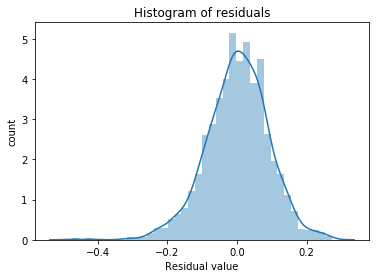

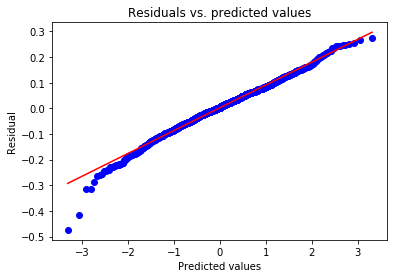

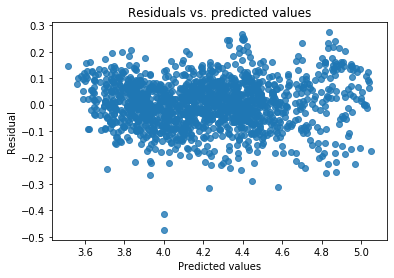

In [21]:
lin_mod_l2 = linear_model.Ridge(alpha = out_l2[0])
lin_mod_l2.fit(x_train, y_train)
y_score_l2 = lin_mod_l2.predict(x_test)

print_metrics(y_test, y_score_l2)
hist_resids(y_test, y_score_l2)  
resid_qq(y_test, y_score_l2) 
resid_plot(y_test, y_score_l2) 

## Apply l1 regularizaton

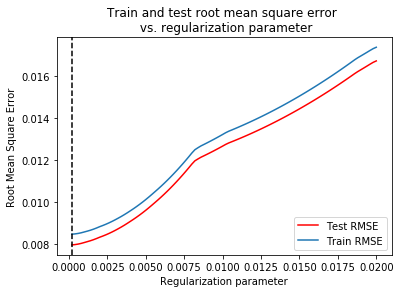

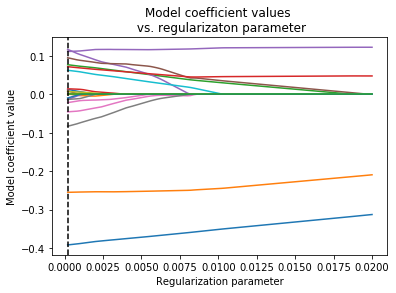

(0.0002, 0.007968061688925398)


In [22]:
def test_regularization_l1(x_train, y_train, x_test, y_test, l1):
    train_RMSE = []
    test_RMSE = []
    coefs = []
    for reg in l1:
        lin_mod = linear_model.Lasso(alpha = reg)
        lin_mod.fit(x_train, y_train)
        coefs.append(lin_mod.coef_)
        y_score_train = lin_mod.predict(x_train)
        train_RMSE.append(sklm.mean_squared_error(y_train, y_score_train))
        y_score = lin_mod.predict(x_test)
        test_RMSE.append(sklm.mean_squared_error(y_test, y_score))
    min_idx = np.argmin(test_RMSE)
    min_l1 = l1[min_idx]
    min_RMSE = test_RMSE[min_idx]
    
    title = 'Train and test root mean square error \n vs. regularization parameter'
    plot_regularization(l1, train_RMSE, test_RMSE, coefs, min_l1, title)
    return min_l1, min_RMSE
    
l1 = [x/5000 for x in range(1,101)]
out_l1 = test_regularization_l1(x_train, y_train, x_test, y_test, l1)
print(out_l1)

Mean Square Error      = 0.007968061688925398
Root Mean Square Error = 0.0892639999603726
Mean Absolute Error    = 0.06919492899501524
Median Absolute Error  = 0.057986549947541155
R^2                    = 0.931732395016994


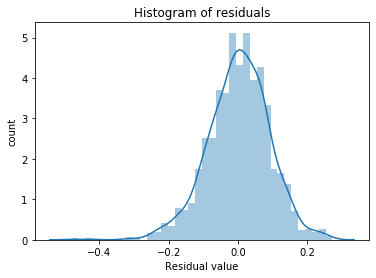

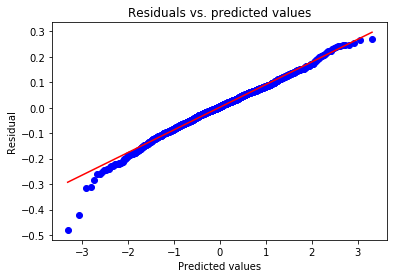

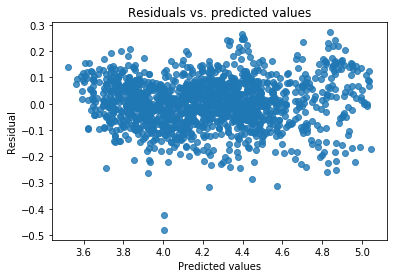

In [23]:
lin_mod_l1 = linear_model.Lasso(alpha = out_l1[0])
lin_mod_l1.fit(x_train, y_train)
y_score_l1 = lin_mod_l1.predict(x_test)

print_metrics(y_test, y_score_l1) 
hist_resids(y_test, y_score_l1)  
resid_qq(y_test, y_score_l1) 
resid_plot(y_test, y_score_l1) 

# Exporting the results for the test


In [24]:
np.savetxt("y_assesment.csv",y_assesment, delimiter=',', fmt='%4.2f')

NameError: name 'y_assesment' is not defined